# Aprendizaje Supervisado

In [1]:
#Importaciones iniciales
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

## Lectura de Datos

Como ya se quitó la estacionalidad en tareas anteriores, ya leemos directamente esos datos.

In [2]:
#Lectura de datos
datosGeneracion = pd.read_excel("../Datasets/Información Planta Solar Estacionaria.xlsx")
datosGeneracion.head(4)

,Fecha,Anio,Mes,NumMes,NumSemana,NumDiaAnio,Dia,NumDia,Hora,NumHora,...,Generacion_diff,Temperatura_diff,ProbabilidadLluvia_diff,HumedadRelativa_diff,VelocidadViento_diff,DireccionViento_diff,IndiceUV_diff,VelocidadRafaga_diff,Precipitacion_diff,DPT_diff
0,2021-07-01 00:00:00,2021,199,7,27,180,6026,1,144600,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-07-01 01:00:00,2021,199,7,27,180,6026,1,144601,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-07-01 02:00:00,2021,199,7,27,180,6026,1,144602,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-07-01 03:00:00,2021,199,7,27,180,6026,1,144603,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Selección de columnas
datosGeneracion_sel = datosGeneracion[['Generacion_diff', 'NumSemana', 'NumDiaAnio', 'Hora', 'CoberturaNubes',
                                        'CodDirViento', 'CodCondCielo', 'HumedadRelativa_diff']]
datosGeneracion_sel.head(4)

,Generacion_diff,NumSemana,NumDiaAnio,Hora,CoberturaNubes,CodDirViento,CodCondCielo,HumedadRelativa_diff
0,NaN,27,180,144600,70,4,4,NaN
1,NaN,27,180,144601,70,4,2,NaN
2,NaN,27,180,144602,70,4,2,NaN
3,NaN,27,180,144603,70,4,2,NaN


In [4]:
#Eliminamos filas vacias (las primeras 24, por el ejercicio de diferenciación)
datosGeneracion_dropna = datosGeneracion_sel.dropna()
datosGeneracion_dropna.head(4)

,Generacion_diff,NumSemana,NumDiaAnio,Hora,CoberturaNubes,CodDirViento,CodCondCielo,HumedadRelativa_diff
24,0.0,27,181,144624,70,4,4,1.0
25,0.0,27,181,144625,70,4,4,0.0
26,0.0,27,181,144626,70,4,2,2.0
27,0.0,27,181,144627,70,4,2,1.0


In [5]:
#Normalizamos los datos con el MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(datosGeneracion_dropna)
datosGeneracion_scaled = pd.DataFrame(scaled, columns = datosGeneracion_dropna.columns, index = datosGeneracion_dropna.index)
datosGeneracion_scaled_r = datosGeneracion_scaled.round(4)
datosGeneracion_scaled_r.head(4)

,Generacion_diff,NumSemana,NumDiaAnio,Hora,CoberturaNubes,CodDirViento,CodCondCielo,HumedadRelativa_diff
24,0.5002,0.5,0.5028,0.0000,0.7,0.375,0.75,0.500
25,0.5002,0.5,0.5028,0.0001,0.7,0.375,0.75,0.494
26,0.5002,0.5,0.5028,0.0001,0.7,0.375,0.25,0.506
27,0.5002,0.5,0.5028,0.0002,0.7,0.375,0.25,0.500


In [6]:
#Imprimimos en formato latex para mostrarlo en el artículo
print(datosGeneracion_scaled_r.iloc[0:4,].to_latex(index = False))

\begin{tabular}{rrrrrrrr}
\toprule
Generacion_diff & NumSemana & NumDiaAnio & Hora & CoberturaNubes & CodDirViento & CodCondCielo & HumedadRelativa_diff \\
\midrule
0.500200 & 0.500000 & 0.502800 & 0.000000 & 0.700000 & 0.375000 & 0.750000 & 0.500000 \\
0.500200 & 0.500000 & 0.502800 & 0.000100 & 0.700000 & 0.375000 & 0.750000 & 0.494000 \\
0.500200 & 0.500000 & 0.502800 & 0.000100 & 0.700000 & 0.375000 & 0.250000 & 0.506000 \\
0.500200 & 0.500000 & 0.502800 & 0.000200 & 0.700000 & 0.375000 & 0.250000 & 0.500000 \\
\bottomrule
\end{tabular}



## Entrenamiento para elegir mejor modelo

In [7]:
#Importaciones de todos los modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, LogisticRegression
import xgboost
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline

In [8]:
def fit(x, y, reg_model = 'RF', n_components = 3, n_jobs = None):
    match reg_model:
        case 'AdaBoost':
            model = AdaBoostRegressor()
        case 'Bagging':
            model = BaggingRegressor(n_jobs = n_jobs)
        case 'BayesRidge':
            model = BayesianRidge()
        case 'Boosting':
            model = GradientBoostingRegressor()
        case 'DecisionTree':
            model = DecisionTreeRegressor(max_depth = 2)
        case 'LassoReg':
            model = Lasso(alpha = 0.1)
        case 'LinearReg':
            model = LinearRegression(n_jobs = n_jobs)
        case 'PLS':
            model = PLSRegression(n_components = n_components)
        case 'PCR':
            model = make_pipeline(PCA(n_components = n_components), LinearRegression(n_jobs = n_jobs))
        case 'RidgeReg':
            model = Ridge(alpha = 0.1)
        case 'RF':
            model = RandomForestRegressor(n_jobs = n_jobs)
        case 'XGBoost':
            model = xgboost.XGBRegressor(n_jobs = n_jobs)
    model.fit(x, y)
    return model

In [9]:
#Librerías de las métricas
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [10]:
y = datosGeneracion_scaled[['Generacion_diff']]
x = datosGeneracion_scaled[['NumSemana', 'NumDiaAnio', 'Hora', 'CoberturaNubes',
                                        'CodDirViento', 'CodCondCielo', 'HumedadRelativa_diff']]

In [11]:
#Datos de Entrenamiento
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(gap=0,max_train_size=None, n_splits=18, test_size=None)

for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f" Train: index={train_index}")
    print(f" Test: index={test_index}")

Fold 0:
 Train: index=[   0    1    2 ... 1009 1010 1011]
 Test: index=[1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025
 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053
 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067
 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081
 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123
 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137
 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151
 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165
 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179
 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193
 1194 

In [12]:
#Datos de Entrenamiento
#Procesamos los modelos
from tqdm import tqdm
import multiprocessing
from timeit import default_timer as timer

models_ed = ['AdaBoost', 'Boosting', 'DecisionTree', 'LassoReg', 'PCR',
                      'Bagging', 'RF', 'LinearReg', 'BayesRidge', 'RidgeReg', 'PLS', 'XGBoost']
n_jobs = multiprocessing.cpu_count()
results_ed = {
        'model' : [],
        'mse' : [],
        'rmse' : [],
        'mae' : [],
        'r2' : [],
        'mape' : [],
        'time' : [],
        'i': [],
        'train': [],
        'test': []
}

for k in tqdm(range(30)):
    for i, (train_index, test_index) in enumerate(tscv.split(x)):
        y_train = y.loc[24:len(train_index),]
        x_train = x.loc[24:len(train_index),]

        y_test = y.loc[test_index]
        x_test = x.loc[test_index]    
    
        for m in models_ed:
                start = timer()
                model = fit(x_train, y_train.Generacion_diff.ravel(), m, n_jobs = n_jobs)
                end = timer()
                y_pred = model.predict(x_test)
                results_ed['model'].append(m)
                results_ed['mse'].append(mse(y_test, y_pred))
                results_ed['rmse'].append(np.sqrt(mse(y_test, y_pred)))
                results_ed['mae'].append(mae(y_test, y_pred))
                results_ed['r2'].append(r2(y_test, y_pred))
                results_ed['mape'].append(mape(y_test, y_pred))
                results_ed['i'].append(i)
                results_ed['train'].append(y_train.index[-1])
                results_ed['test'].append(y_test.index[-1])
                results_ed['time'].append(end - start)

df_results_ed = pd.DataFrame(results_ed)
df_results_ed.to_csv('./Resultados_modelos_PCA5.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [1:06:57<00:00, 133.92s/it]


## RMSE

In [79]:
df_results_ed = pd.read_csv('./Resultados_modelos_PCA.csv', index_col = 0)

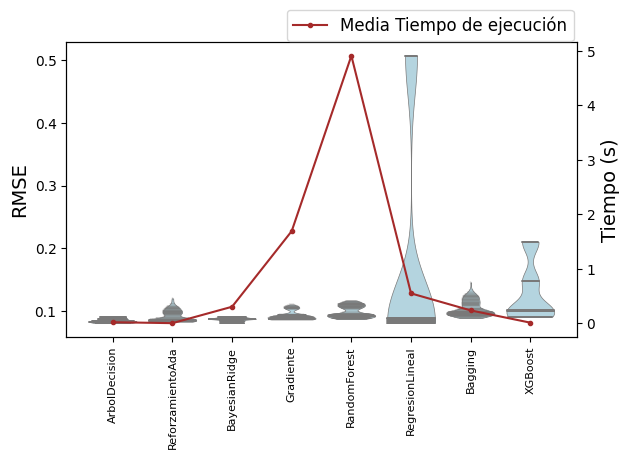

In [86]:
filter = df_results_ed["i"]==0
ff_results_ed = df_results_ed.where(filter).sort_values('rmse')
gp_results_ed = ff_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('rmse')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="rmse", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## MAE

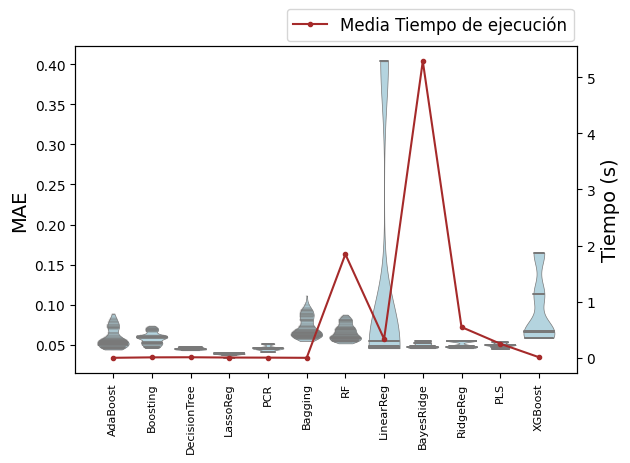

In [409]:
filter = df_results_ed["i"]==3
ff_results_ed = df_results_ed.sort_values('mae')
gp_results_ed = ff_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('mae')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="mae", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## R2

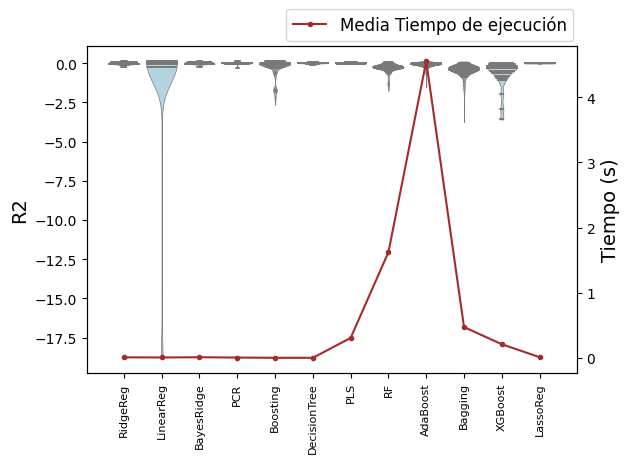

In [13]:
df_results_ed = df_results_ed.sort_values('r2', ascending=False)
gp_results_ed = df_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('r2', ascending=False)
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="r2", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('R2', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

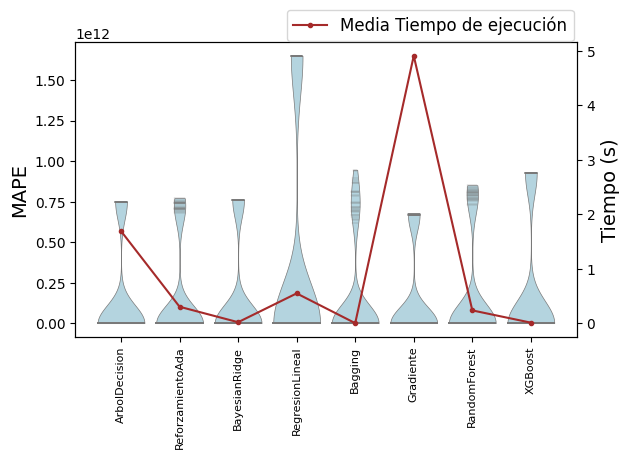

In [49]:
df_results_ed = df_results_ed.sort_values('mape')
gp_results_ed = df_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('mape')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="mape", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel('MAPE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Media Tiempo de ejecución')
plt.ylabel('Tiempo (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## Método Random Forest

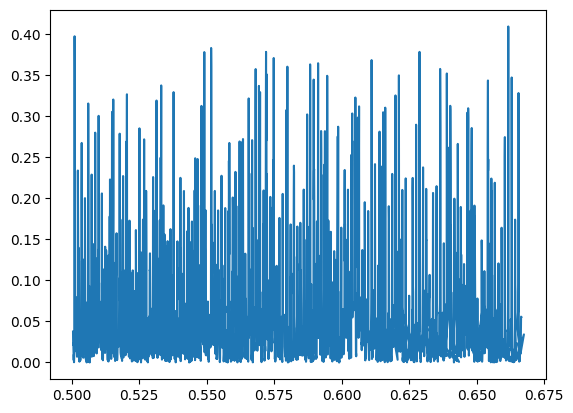

In [1098]:
i = 2
#modelRF = DecisionTreeRegressor(max_depth=2, max_features='log2', min_samples_leaf=4, min_samples_split=5)
#modelRF = Lasso(alpha=0.001)
modelRF = BayesianRidge(alpha_1= 1e-06, alpha_2= 0.0001, lambda_1= 0.0001, lambda_2= 1e-06)
inicio_train = 24
if i == 0:
    fin_train = 3156
    inicio_test =  3157
    fin_test = 6309
elif i == 1:
    fin_train = 6309
    inicio_test =  6310
    fin_test = 9462
elif i == 2:
    fin_train = 9462
    inicio_test =  9463
    fin_test = 12615
elif i == 3:
    fin_train = 12615
    inicio_test =  12616
    fin_test = 15768
elif i == 4:
    fin_train = 15768
    inicio_test =  15769
    fin_test = 18921

y_train = y.loc[inicio_train:fin_train,]
x_train = x.loc[inicio_train:fin_train,]

y_test = y.loc[inicio_test:fin_test,]
x_test = x.loc[inicio_test:fin_test,]
modelRF.fit(x_train, y_train)
y_pred_RF = modelRF.predict(x_test)
plt.plot(x_test["Hora"], abs(y_test["Generacion_diff"]- y_pred_RF))


In [1099]:
df_y_pred = pd.DataFrame(y_pred_RF, index = y_test.index, columns = ['Generacion_diff'])
df_y_pred

,Generacion_diff
9463,0.462553
9464,0.478987
9465,0.476835
9466,0.482740
9467,0.494556
...,...
12611,0.525930
12612,0.542802
12613,0.555965
12614,0.555723


In [1100]:
#Indicamos las filas que han sido predecidas por el método Bagging
datosGeneracion['predecida'] = 0
datosGeneracion.loc[df_y_pred.index, 'predecida'] = 1

In [1101]:
#Igualamos la predición con la generación
datosGeneracion['prediccion_diff'] = datosGeneracion_scaled['Generacion_diff']

In [1102]:
#Asignamos los datos de predicción a la columna
datosGeneracion.loc[df_y_pred.index, 'prediccion_diff'] = df_y_pred['Generacion_diff']

In [1103]:
#Obtenemos el máximo y el mínimo para desecalar
max_value = datosGeneracion_dropna["Generacion_diff"].max()
min_value = datosGeneracion_dropna["Generacion_diff"].min()

In [1104]:
#Desescalamos
datosGeneracion["Prediction"] = round((datosGeneracion["prediccion_diff"] * (max_value - min_value)) + min_value, 2)

In [1105]:
#Inicializamos la columna de predicción final con 0
datosGeneracion['Prediction_final'] = 0

In [1106]:
#Pasamos los primeros 24 registros de la generación original a las columnas predictivas
datosGeneracion.loc[0:24, 'Prediction'] = datosGeneracion.loc[0:24, 'Generacion']
datosGeneracion.loc[0:24, 'Prediction_final'] = datosGeneracion.loc[0:24, 'Generacion']

In [1107]:
#Desdiferenciamos topando mínimo con 0 y máximo con 30000
for i in range(24, len(datosGeneracion)):
    datosGeneracion['Prediction_final'][i] = min(max(datosGeneracion['Prediction'][i] + datosGeneracion["Prediction_final"][i-24], 0), 30000)

In [1108]:
#Condicionamos a que haya valores si el Índice UV tiene valor
datosGeneracion['Prediction_UV'] = datosGeneracion['Prediction_final']
datosGeneracion.loc[(datosGeneracion['IndiceUV'] == 0), 'Prediction_UV'] = 0

In [1109]:
mae(datosGeneracion[['Generacion']], datosGeneracion[['Prediction_final']])

8280.936730454978

In [1110]:
mae(datosGeneracion[['Generacion']], datosGeneracion[['Prediction_UV']])

1247.4684442573634

In [1111]:
datosGeneracion.loc[-50:,['Generacion', 'Prediction', 'Prediction_final', 'Prediction_final', 'predecida']]

,Generacion,Prediction,Prediction_final,Prediction_final,predecida
0,0.0000,0.00,0.00,0.00,0
1,0.0000,0.00,0.00,0.00,0
2,0.0000,0.00,0.00,0.00,0
3,0.0000,0.00,0.00,0.00,0
4,0.0000,0.00,0.00,0.00,0
...,...,...,...,...,...
18941,1732.7788,1165.22,18950.85,18950.85,0
18942,0.0000,-0.00,28423.34,28423.34,0
18943,0.0000,-0.00,28941.19,28941.19,0
18944,0.0000,-0.00,23999.69,23999.69,0


In [1112]:
def line_plotting(title, data, x, y, y2, x_label, y_label, width, height):
    """General function to plot"""
    plt.figure(figsize=(width,height))
    plt.plot(data[x], data[y], color='lightblue')   
    plt.plot(data[x], data[y2], color='black')  
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

Text(0.5, 0, 'Fecha')

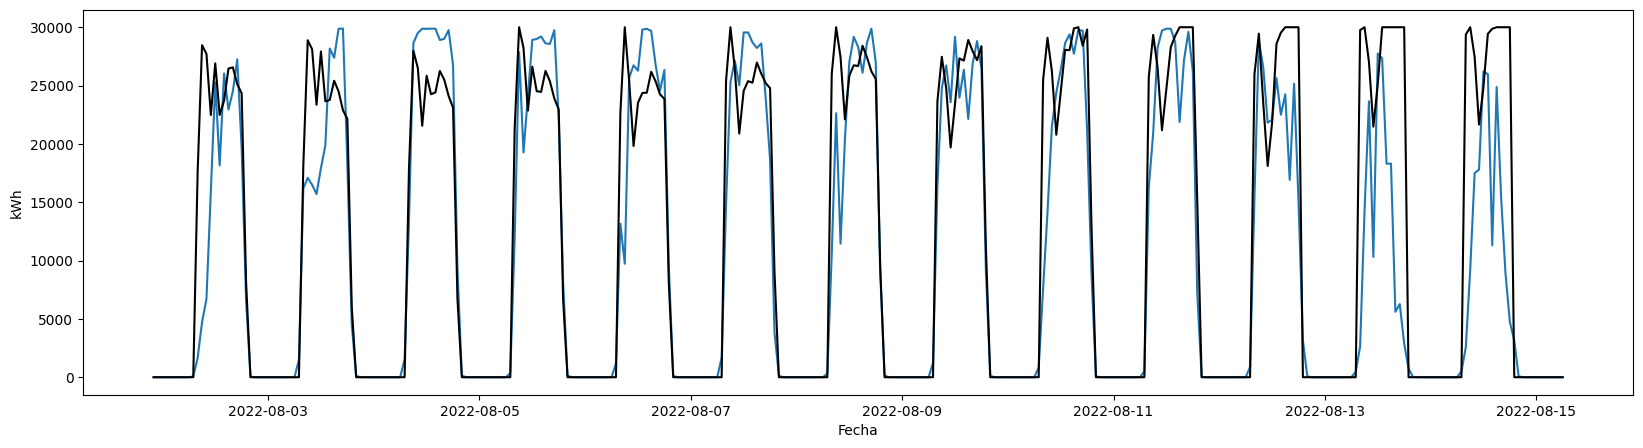

In [1113]:
plt.figure(figsize=(20,5))
fin = inicio_test + 320
plt.plot(datosGeneracion.loc[inicio_test:fin, "Fecha"], datosGeneracion.loc[inicio_test:fin, "Generacion"])
plt.plot(datosGeneracion.loc[inicio_test:fin, "Fecha"], datosGeneracion.loc[inicio_test:fin, "Prediction_UV"], c = 'black')
plt.ylabel('kWh')
plt.xlabel('Fecha')

In [1119]:
#metodos = pd.DataFrame()
#metodos['Generacion'] = datosGeneracion['Generacion']
#metodos['BR'] = datosGeneracion['Prediction_UV']
#metodos['Residual_BR'] = abs(datosGeneracion['Generacion'] - datosGeneracion['Prediction_UV'])


In [1129]:
mae(datosGeneracion.loc[inicio_test:fin_test, ['Generacion']], datosGeneracion.loc[inicio_test:fin_test, ['Prediction_UV']])

4093.736792039328

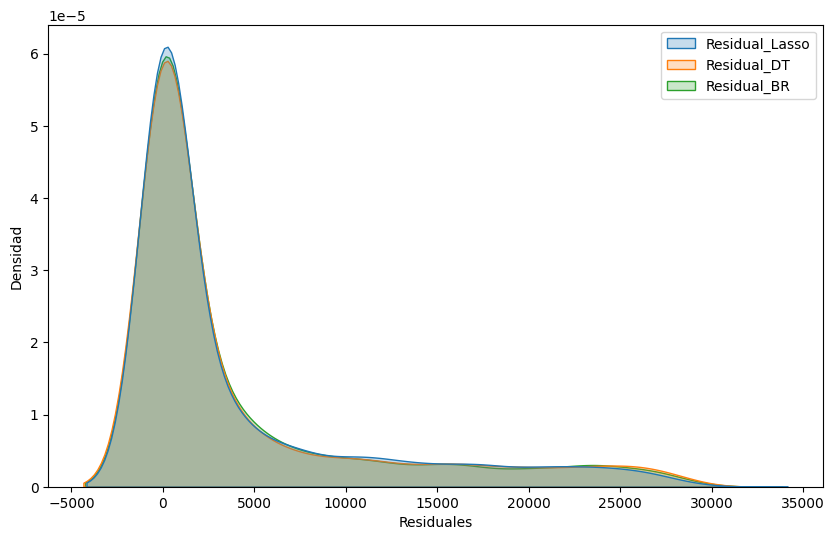

In [1125]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=metodos.loc[inicio_test:fin_test,['Residual_Lasso', 'Residual_DT', 'Residual_BR']], fill=True)
plt.xlabel('Residuales')
plt.ylabel('Densidad')
plt.show()

In [1130]:
metricas = pd.DataFrame()
metricas.loc[0, 'Método'] = "Lasso"
metricas.loc[0, 'MAE'] = mae(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['Lasso']])
metricas.loc[0, 'MAPE'] = mape(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['Lasso']])
metricas.loc[0, 'RMSE'] = np.sqrt(mse(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['Lasso']]))
metricas.loc[0, 'R2'] = r2(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['Lasso']])

metricas.loc[1, 'Método'] = "Decision Tree"
metricas.loc[1, 'MAE'] = mae(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['DT']])
metricas.loc[1, 'MAPE'] = mape(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['DT']])
metricas.loc[1, 'RMSE'] = np.sqrt(mse(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['DT']]))
metricas.loc[1, 'R2'] = r2(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['DT']])

metricas.loc[2, 'Método'] = "Bayesian Ridge"
metricas.loc[2, 'MAE'] = mae(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['BR']])
metricas.loc[2, 'MAPE'] = mape(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['BR']])
metricas.loc[2, 'RMSE'] = np.sqrt(mse(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['BR']]))
metricas.loc[2, 'R2'] = r2(metodos.loc[inicio_test:fin_test,['Generacion']], metodos.loc[inicio_test:fin_test,['BR']])


In [1132]:
metricas.to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\nMétodo & MAE & MAPE & RMSE & R2 \\\\\n\\midrule\nLasso & 4045.031443 & 2.816051 & 8062.458485 & 0.497956 \\\\\nDecision Tree & 4176.508018 & 2.515355 & 8375.231830 & 0.458248 \\\\\nBayesian Ridge & 4093.736792 & 2.750923 & 8206.588294 & 0.479846 \\\\\n\\bottomrule\n\\end{tabular}\n'

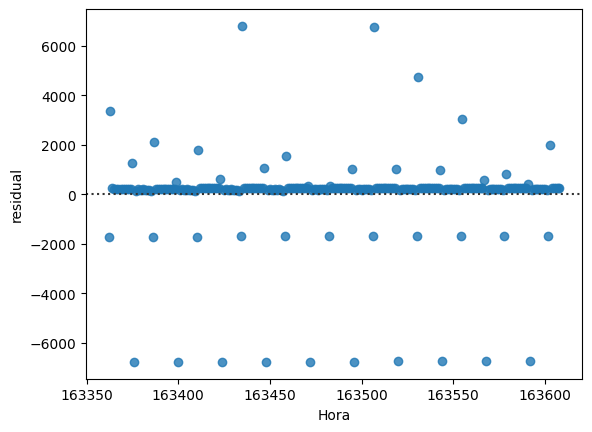

In [1118]:
import seaborn as sns

datosGeneracion["residual"] = datosGeneracion["Generacion"] - datosGeneracion["Prediction_UV"]

sns.residplot(x='Hora', y='residual', data=datosGeneracion[18700:])
plt.show() 